In [92]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import torchio as tio
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import torch.nn.functional as F
import os
import shutil
import csv

from segmenter import Segmenter

In [68]:
# TODO CMD arguments
version_folder = "version_17"
device = "cuda"
root = "C:/Users/denni/Documents/fallstudie-ss2024/logs/lightning_logs/"
data_root = "D:/Deep Learning/Task01_BrainTumour/"
output_images_root = "C:/Users/denni/Documents/fallstudie-ss2024/eval/" + version_folder
slices_to_show = [30, 40, 50, 60, 70, 80, 90, 100, 110]
# input patch size
# train_test_split
# patch overlap

In [71]:
if not os.path.isdir(output_images_root + "/images/"):
    os.makedirs(output_images_root + "/images/")
if not os.path.isdir(output_images_root + "/model/"):
    os.makedirs(output_images_root + "/model/")
if not os.path.isdir(output_images_root + "/metadata/"):
    os.makedirs(output_images_root + "/metadata/")

In [4]:
def get_models_and_metadata(version_path: str):
    path = Path(version_path + "/checkpoints")
    
    checkpoint_paths = list(path.glob("*"))
    model_list = []
    metadata_list = []
    
    for path in checkpoint_paths:        
        metadata = torch.load(path)
        metadata_list.append(metadata)
        
        # Dirty fix
        if "batch_size" not in metadata["hyper_parameters"]:
            model = Segmenter.load_from_checkpoint(path, batch_size=4)
        else:
            model = Segmenter.load_from_checkpoint(path)
        model_list.append(model)
        
    return model_list, metadata_list

In [5]:
models, metadatas = get_models_and_metadata(root + version_folder)

C:\Users\denni\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:199: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
C:\Users\denni\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:199: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.


In [6]:
def change_img_to_label_path(path):
    """ Returns all directories in a path. """
    parts = list(path.parts)
    # Replace path
    parts[parts.index("imagesTr")] = "labelsTr"
    return Path(*parts)

In [7]:
path = Path(data_root + "/imagesTr")
subject_paths = list(path.glob("BRATS_*"))
subjects = []

for subject_path in subject_paths:
    label_path = change_img_to_label_path(subject_path)
    subject = tio.Subject({"MRI": tio.ScalarImage(subject_path), 
                        "Label": tio.LabelMap(label_path)})
    subjects.append(subject)

In [8]:
# Validation data processing
process = tio.Compose([
    tio.CropOrPad((240, 240, 155)),
    tio.RescaleIntensity((-1, 1))
])

In [9]:
num_subjects = len(subjects)
train_split = 0.85
split_index = int(num_subjects * train_split)
val_dataset = tio.SubjectsDataset(subjects[split_index:], transform=process)

In [10]:
class DiceLoss(torch.nn.Module):
    """ A scratch implementation of Dice loss. Forward computes the loss between the prediction and the
     true value, i.e., the mask. """
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):
        pred_new = torch.flatten(pred)
        mask_new = torch.flatten(mask)
        return 1 - (2 * (pred_new * mask_new).sum() + 1) / (pred_new.sum() + mask_new.sum() + 1)

In [11]:
def masked(a):
    return np.ma.masked_where(a == 0, a)

In [12]:
def show_mri_and_pred(subject_num, slice_num, pred, train=False, save=False):
    plt.figure()
    ground_truth = val_dataset if not train else train_dataset
    plt.imshow(ground_truth[subject_num]["MRI"].data[0,:,:,slice_num], cmap="bone")
    max_likelihood_pred = pred.argmax(0)
    plt.imshow(masked(max_likelihood_pred[:, :, slice_num]), alpha=0.5, cmap="autumn")
    title_start = "Training" if train else "Eval"
    plt.title(f"{title_start} subject {subject_num}, slice {slice_num}")
    plt.suptitle("Prediction", y=0.05, fontsize=10)
    if save:
        plt.savefig(f"{subject_num}-{slice_num}.png")

In [13]:
def show_all(subject_num, slice_num, pred, train=False, save=False, save_root_path="imgs/", save_file_name="",
             extra_pred_text=""):
    # plt.figure(figsize=(20, 20))
    if save:
        plt.ioff()
    f, ax = plt.subplots(2)
    # Show ground truth image
    ground_truth = val_dataset if not train else train_dataset
    ax[0].set_position([0, 0, 0.8, 0.8])
    ax[0].imshow(ground_truth[subject_num]["MRI"].data[0,:,:,slice_num], cmap="bone")
    ax[0].imshow(masked(ground_truth[subject_num]["Label"].data[0,:,:,slice_num]), alpha=0.5,
                                  cmap="autumn")
    title_start = "Training" if train else "Eval"
    ax[0].set_title(f"{title_start} subject {subject_num}, slice {slice_num} \n(ground truth)")
    # ax[0].legend("Ground truth", y=0.05, fontsize=10)
    
    # Show prediction image
    ground_truth = val_dataset if not train else train_dataset
    ax[1].set_position([0.75, 0, 0.8, 0.8])
    ax[1].imshow(ground_truth[subject_num]["MRI"].data[0,:,:,slice_num], cmap="bone")
    max_likelihood_pred = pred.argmax(0)
    ax[1].imshow(masked(max_likelihood_pred[:, :, slice_num]), alpha=0.5, cmap="autumn")
    title_start = "Training" if train else "Eval"
    extra_text = "" if extra_pred_text == "" else ", " + extra_pred_text
    ax[1].set_title(f"{title_start} subject {subject_num}, slice {slice_num} \n(pred{extra_text})")
    if save:
        plt.savefig(f"{save_root_path}/{save_file_name}.png", dpi=200, bbox_inches="tight")
        plt.ion()
    plt.close()

In [14]:
def save_plots_for_index(pred, subject_num, slices, save_root_path, save_file_name, extra_pred_text=""):
    for slice_num in slices:
        show_all(subject_num, slice_num, pred.squeeze(), save=True, save_root_path=save_root_path, 
                 save_file_name=save_file_name + f"-slice={slice_num}", extra_pred_text=extra_pred_text)

In [57]:
# Iterate all saved checkpoints, i.e., the model with the metadata and find out which one performs best on the
# validation data. That best model will be used to perform more in-depth analysis on the loss and to visualize
# the segmented tumors of the model.
loss_per_model = []
all_losses = []

for index, (model, metadata) in enumerate(zip(models, metadatas)):
    # Switch the model to eval mode
    model.eval()
    model.to(device)
    total_loss = 0.0
    epoch = metadatas[index]['epoch']
    preds = []
    losses = []
    
    print(f"Evaluating model no. {index} for epoch {epoch}")
    
    # Load the patches from the current subject
    for subject_num in tqdm(range(len((val_dataset)))):
        grid_sampler = tio.inference.GridSampler(val_dataset[subject_num], 96, (8, 8, 8))
        aggregator = tio.inference.GridAggregator(grid_sampler)
        patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=4)
        
        with torch.no_grad():
            for patches_batch in patch_loader:
                input_tensor = patches_batch["MRI"]["data"].to(device)
                locations = patches_batch[tio.LOCATION]
                pred = model(input_tensor)
                # We keep adding batches to the aggregator to later collect all the data.
                aggregator.add_batch(pred, locations)
        
        pred = torch.swapaxes(F.one_hot(aggregator.get_output_tensor().argmax(0)).unsqueeze(dim=0), 0, 4).squeeze()
        label = torch.swapaxes(F.one_hot(val_dataset[0]["Label"].data.long()), 0, 4).squeeze()
        
        # If the first element is not a channel dimension, add that dimension.
        if pred.shape[0] > 6:
            pred = pred.unsqueeze(dim=0)
            
        # Extend the number of channels of the prediction to 4 if necessary.
        for it in range(pred.shape[0], label.shape[0]):
            pred = torch.cat((pred, torch.zeros_like(pred[0]).unsqueeze(0)), 0)
        
        # Elementwise equality check
        loss = DiceLoss()(pred, label)
        preds.append(pred)
        losses.append(loss)
        total_loss += loss
        
    
    average_loss = total_loss / len(val_dataset)
    loss_per_model.append((average_loss, epoch))
    print(f"Average loss: {average_loss}")
    
    # Visualization for the 0th, 25th, 50th, 75th, and 100th percentile of the losses.
    mod_losses = [(loss, index) for index, loss in enumerate(losses)]
    sorted_losses = sorted(mod_losses)
    print("All losses:", sorted_losses)
    all_losses.append(sorted_losses)

    # The loss of the worst prediction (0th percentile).
    worst_loss, worst_index = sorted_losses[-1]
    # The loss of the 25th percentile prediction.
    perc_25_loss, perc_25_index = sorted_losses[int(len(sorted_losses) * 0.75)]
    # The median loss of the predictions (50th percentile).
    median_loss, median_index = sorted_losses[int(len(sorted_losses) * 0.5)]
    # The loss of the 75th percentile prediction.
    perc_75_loss, perc_75_index = sorted_losses[int(len(sorted_losses) * 0.25)]
    # The loss of the best prediction (100th percentile).
    best_loss, best_index = sorted_losses[0]
    
    # Visualize all of the losses for the specified slice indices.
    save_plots_for_index(preds[worst_index], worst_index, slices_to_show, output_images_root + "/images/",
                         f"epoch={epoch}-perc=0", f"0th percentile, loss={worst_loss * 100:.2f}%")
    
    save_plots_for_index(preds[perc_25_index], perc_25_index, slices_to_show, output_images_root + "/images/",
                         f"epoch={epoch}-perc=25", f"25th percentile, loss={perc_25_loss * 100:.2f}%")
    
    save_plots_for_index(preds[median_index], median_index, slices_to_show, output_images_root + "/images/",
                         f"epoch={epoch}-perc=50", f"50th percentile, loss={median_loss * 100:.2f}%")
    
    save_plots_for_index(preds[perc_75_index], perc_75_index, slices_to_show, output_images_root + "/images/",
                         f"epoch={epoch}-perc=75", f"75th percentile, loss={perc_75_loss * 100:.2f}%")
    
    save_plots_for_index(preds[best_index], best_index, slices_to_show, output_images_root + "/images/",
                         f"epoch={epoch}-perc=100", f"100th percentile, loss={best_loss * 100:.2f}%")
    
print(sorted(loss_per_model))

Evaluating model no. 0 for epoch 32


  0%|          | 0/73 [00:00<?, ?it/s]

Average loss: 0.027769239619374275
All losses: [(tensor(0.0123), 0), (tensor(0.0186), 18), (tensor(0.0189), 61), (tensor(0.0191), 26), (tensor(0.0191), 8), (tensor(0.0195), 4), (tensor(0.0196), 71), (tensor(0.0197), 47), (tensor(0.0199), 41), (tensor(0.0199), 48), (tensor(0.0202), 19), (tensor(0.0204), 35), (tensor(0.0207), 12), (tensor(0.0211), 29), (tensor(0.0212), 31), (tensor(0.0217), 54), (tensor(0.0217), 40), (tensor(0.0218), 50), (tensor(0.0220), 68), (tensor(0.0224), 1), (tensor(0.0226), 32), (tensor(0.0227), 44), (tensor(0.0233), 52), (tensor(0.0237), 67), (tensor(0.0237), 30), (tensor(0.0239), 51), (tensor(0.0241), 6), (tensor(0.0244), 33), (tensor(0.0248), 42), (tensor(0.0249), 27), (tensor(0.0251), 24), (tensor(0.0252), 13), (tensor(0.0252), 43), (tensor(0.0255), 69), (tensor(0.0260), 56), (tensor(0.0266), 16), (tensor(0.0267), 28), (tensor(0.0267), 46), (tensor(0.0268), 11), (tensor(0.0268), 65), (tensor(0.0269), 39), (tensor(0.0269), 23), (tensor(0.0269), 38), (tensor(0.0

  0%|          | 0/73 [00:00<?, ?it/s]

Average loss: 0.026325395330786705
All losses: [(tensor(0.0130), 0), (tensor(0.0175), 35), (tensor(0.0186), 8), (tensor(0.0188), 18), (tensor(0.0189), 26), (tensor(0.0190), 61), (tensor(0.0193), 48), (tensor(0.0193), 4), (tensor(0.0193), 41), (tensor(0.0194), 19), (tensor(0.0194), 12), (tensor(0.0194), 71), (tensor(0.0195), 47), (tensor(0.0207), 50), (tensor(0.0208), 44), (tensor(0.0210), 32), (tensor(0.0211), 29), (tensor(0.0212), 31), (tensor(0.0212), 54), (tensor(0.0213), 40), (tensor(0.0214), 1), (tensor(0.0217), 68), (tensor(0.0219), 67), (tensor(0.0221), 39), (tensor(0.0223), 52), (tensor(0.0225), 6), (tensor(0.0230), 51), (tensor(0.0230), 30), (tensor(0.0231), 42), (tensor(0.0236), 33), (tensor(0.0237), 56), (tensor(0.0237), 22), (tensor(0.0241), 27), (tensor(0.0244), 69), (tensor(0.0244), 24), (tensor(0.0251), 13), (tensor(0.0251), 28), (tensor(0.0256), 43), (tensor(0.0256), 23), (tensor(0.0257), 17), (tensor(0.0257), 46), (tensor(0.0260), 66), (tensor(0.0261), 11), (tensor(0.0

  0%|          | 0/73 [00:00<?, ?it/s]

Average loss: 0.026440110057592392
All losses: [(tensor(0.0134), 0), (tensor(0.0176), 35), (tensor(0.0190), 26), (tensor(0.0190), 18), (tensor(0.0193), 61), (tensor(0.0193), 8), (tensor(0.0193), 4), (tensor(0.0193), 41), (tensor(0.0194), 48), (tensor(0.0194), 12), (tensor(0.0194), 47), (tensor(0.0196), 71), (tensor(0.0196), 19), (tensor(0.0202), 44), (tensor(0.0203), 32), (tensor(0.0206), 50), (tensor(0.0210), 67), (tensor(0.0211), 31), (tensor(0.0212), 40), (tensor(0.0213), 1), (tensor(0.0214), 39), (tensor(0.0214), 29), (tensor(0.0214), 54), (tensor(0.0222), 68), (tensor(0.0226), 52), (tensor(0.0228), 30), (tensor(0.0231), 6), (tensor(0.0231), 56), (tensor(0.0232), 42), (tensor(0.0233), 51), (tensor(0.0235), 72), (tensor(0.0240), 22), (tensor(0.0241), 33), (tensor(0.0241), 27), (tensor(0.0243), 69), (tensor(0.0243), 23), (tensor(0.0244), 28), (tensor(0.0245), 24), (tensor(0.0250), 13), (tensor(0.0258), 11), (tensor(0.0261), 46), (tensor(0.0265), 16), (tensor(0.0265), 43), (tensor(0.0

  0%|          | 0/73 [00:00<?, ?it/s]

Average loss: 0.02683955803513527
All losses: [(tensor(0.0127), 0), (tensor(0.0172), 35), (tensor(0.0180), 8), (tensor(0.0188), 18), (tensor(0.0189), 61), (tensor(0.0191), 26), (tensor(0.0194), 71), (tensor(0.0199), 47), (tensor(0.0200), 41), (tensor(0.0200), 19), (tensor(0.0202), 4), (tensor(0.0207), 39), (tensor(0.0209), 12), (tensor(0.0210), 29), (tensor(0.0215), 54), (tensor(0.0216), 68), (tensor(0.0216), 40), (tensor(0.0216), 31), (tensor(0.0217), 32), (tensor(0.0220), 50), (tensor(0.0222), 52), (tensor(0.0225), 44), (tensor(0.0229), 1), (tensor(0.0233), 33), (tensor(0.0236), 30), (tensor(0.0238), 22), (tensor(0.0239), 6), (tensor(0.0240), 51), (tensor(0.0240), 65), (tensor(0.0243), 24), (tensor(0.0245), 42), (tensor(0.0248), 67), (tensor(0.0249), 27), (tensor(0.0251), 17), (tensor(0.0252), 43), (tensor(0.0255), 56), (tensor(0.0256), 13), (tensor(0.0257), 16), (tensor(0.0259), 28), (tensor(0.0259), 46), (tensor(0.0260), 69), (tensor(0.0267), 66), (tensor(0.0273), 48), (tensor(0.02

  0%|          | 0/73 [00:00<?, ?it/s]

Average loss: 0.026501942425966263
All losses: [(tensor(0.0144), 0), (tensor(0.0181), 35), (tensor(0.0189), 18), (tensor(0.0190), 26), (tensor(0.0191), 61), (tensor(0.0191), 71), (tensor(0.0192), 4), (tensor(0.0194), 8), (tensor(0.0196), 48), (tensor(0.0197), 47), (tensor(0.0198), 19), (tensor(0.0201), 12), (tensor(0.0202), 41), (tensor(0.0203), 29), (tensor(0.0205), 68), (tensor(0.0211), 54), (tensor(0.0211), 31), (tensor(0.0212), 50), (tensor(0.0215), 32), (tensor(0.0216), 1), (tensor(0.0216), 39), (tensor(0.0219), 40), (tensor(0.0225), 52), (tensor(0.0227), 6), (tensor(0.0234), 22), (tensor(0.0235), 51), (tensor(0.0235), 42), (tensor(0.0235), 67), (tensor(0.0235), 33), (tensor(0.0241), 30), (tensor(0.0241), 27), (tensor(0.0244), 70), (tensor(0.0244), 44), (tensor(0.0245), 69), (tensor(0.0246), 24), (tensor(0.0251), 13), (tensor(0.0255), 56), (tensor(0.0255), 16), (tensor(0.0256), 72), (tensor(0.0257), 28), (tensor(0.0257), 43), (tensor(0.0261), 23), (tensor(0.0262), 46), (tensor(0.0

  0%|          | 0/73 [00:00<?, ?it/s]

Average loss: 0.02749599516391754
All losses: [(tensor(0.0132), 0), (tensor(0.0185), 35), (tensor(0.0185), 18), (tensor(0.0192), 26), (tensor(0.0192), 61), (tensor(0.0193), 4), (tensor(0.0193), 41), (tensor(0.0195), 47), (tensor(0.0196), 12), (tensor(0.0199), 48), (tensor(0.0200), 8), (tensor(0.0201), 71), (tensor(0.0204), 19), (tensor(0.0211), 31), (tensor(0.0211), 50), (tensor(0.0214), 54), (tensor(0.0219), 40), (tensor(0.0219), 32), (tensor(0.0223), 68), (tensor(0.0224), 29), (tensor(0.0227), 1), (tensor(0.0231), 44), (tensor(0.0233), 52), (tensor(0.0236), 6), (tensor(0.0237), 67), (tensor(0.0238), 42), (tensor(0.0240), 30), (tensor(0.0240), 51), (tensor(0.0242), 33), (tensor(0.0246), 24), (tensor(0.0251), 13), (tensor(0.0254), 56), (tensor(0.0255), 69), (tensor(0.0257), 27), (tensor(0.0259), 39), (tensor(0.0259), 46), (tensor(0.0260), 17), (tensor(0.0261), 43), (tensor(0.0261), 16), (tensor(0.0264), 11), (tensor(0.0264), 38), (tensor(0.0267), 28), (tensor(0.0272), 65), (tensor(0.02

  0%|          | 0/73 [00:00<?, ?it/s]

Average loss: 0.026038486510515213
All losses: [(tensor(0.0108), 0), (tensor(0.0176), 35), (tensor(0.0186), 18), (tensor(0.0189), 26), (tensor(0.0191), 61), (tensor(0.0192), 8), (tensor(0.0193), 4), (tensor(0.0193), 41), (tensor(0.0193), 48), (tensor(0.0195), 47), (tensor(0.0195), 71), (tensor(0.0195), 19), (tensor(0.0197), 12), (tensor(0.0204), 29), (tensor(0.0210), 32), (tensor(0.0211), 31), (tensor(0.0211), 44), (tensor(0.0211), 50), (tensor(0.0213), 68), (tensor(0.0214), 54), (tensor(0.0217), 40), (tensor(0.0217), 1), (tensor(0.0217), 39), (tensor(0.0221), 52), (tensor(0.0226), 6), (tensor(0.0229), 51), (tensor(0.0232), 42), (tensor(0.0232), 30), (tensor(0.0233), 67), (tensor(0.0233), 33), (tensor(0.0234), 22), (tensor(0.0234), 56), (tensor(0.0239), 24), (tensor(0.0240), 16), (tensor(0.0240), 27), (tensor(0.0244), 69), (tensor(0.0247), 43), (tensor(0.0248), 65), (tensor(0.0249), 13), (tensor(0.0254), 46), (tensor(0.0255), 28), (tensor(0.0256), 17), (tensor(0.0261), 23), (tensor(0.0

  0%|          | 0/73 [00:00<?, ?it/s]

Average loss: 0.02665194496512413
All losses: [(tensor(0.0135), 0), (tensor(0.0174), 35), (tensor(0.0186), 18), (tensor(0.0189), 61), (tensor(0.0190), 26), (tensor(0.0192), 8), (tensor(0.0192), 4), (tensor(0.0193), 48), (tensor(0.0195), 41), (tensor(0.0195), 71), (tensor(0.0196), 47), (tensor(0.0200), 19), (tensor(0.0200), 12), (tensor(0.0209), 50), (tensor(0.0211), 32), (tensor(0.0213), 44), (tensor(0.0213), 31), (tensor(0.0214), 65), (tensor(0.0216), 54), (tensor(0.0217), 29), (tensor(0.0218), 40), (tensor(0.0220), 39), (tensor(0.0222), 1), (tensor(0.0222), 52), (tensor(0.0225), 68), (tensor(0.0230), 6), (tensor(0.0232), 30), (tensor(0.0234), 51), (tensor(0.0235), 56), (tensor(0.0237), 67), (tensor(0.0238), 33), (tensor(0.0244), 42), (tensor(0.0245), 24), (tensor(0.0247), 22), (tensor(0.0247), 27), (tensor(0.0249), 69), (tensor(0.0253), 13), (tensor(0.0256), 16), (tensor(0.0258), 17), (tensor(0.0259), 46), (tensor(0.0260), 43), (tensor(0.0261), 11), (tensor(0.0262), 28), (tensor(0.02

  0%|          | 0/73 [00:00<?, ?it/s]

Average loss: 0.026642076671123505
All losses: [(tensor(0.0130), 0), (tensor(0.0175), 35), (tensor(0.0185), 18), (tensor(0.0187), 8), (tensor(0.0189), 61), (tensor(0.0189), 26), (tensor(0.0193), 48), (tensor(0.0193), 41), (tensor(0.0194), 71), (tensor(0.0195), 47), (tensor(0.0198), 19), (tensor(0.0198), 12), (tensor(0.0198), 44), (tensor(0.0204), 4), (tensor(0.0208), 29), (tensor(0.0209), 50), (tensor(0.0209), 32), (tensor(0.0209), 68), (tensor(0.0213), 31), (tensor(0.0214), 40), (tensor(0.0215), 54), (tensor(0.0218), 39), (tensor(0.0220), 52), (tensor(0.0220), 1), (tensor(0.0227), 56), (tensor(0.0228), 30), (tensor(0.0228), 6), (tensor(0.0232), 67), (tensor(0.0233), 51), (tensor(0.0233), 33), (tensor(0.0240), 42), (tensor(0.0243), 22), (tensor(0.0243), 27), (tensor(0.0245), 69), (tensor(0.0246), 24), (tensor(0.0253), 13), (tensor(0.0256), 46), (tensor(0.0256), 28), (tensor(0.0257), 43), (tensor(0.0260), 65), (tensor(0.0262), 72), (tensor(0.0262), 16), (tensor(0.0263), 11), (tensor(0.0

  0%|          | 0/73 [00:00<?, ?it/s]

Average loss: 0.027427464723587036
All losses: [(tensor(0.0139), 0), (tensor(0.0176), 35), (tensor(0.0188), 18), (tensor(0.0188), 61), (tensor(0.0189), 26), (tensor(0.0189), 71), (tensor(0.0192), 8), (tensor(0.0194), 41), (tensor(0.0194), 4), (tensor(0.0197), 47), (tensor(0.0198), 19), (tensor(0.0209), 50), (tensor(0.0210), 12), (tensor(0.0211), 32), (tensor(0.0211), 44), (tensor(0.0212), 31), (tensor(0.0215), 54), (tensor(0.0218), 40), (tensor(0.0219), 29), (tensor(0.0222), 39), (tensor(0.0222), 52), (tensor(0.0222), 1), (tensor(0.0225), 56), (tensor(0.0225), 68), (tensor(0.0227), 6), (tensor(0.0230), 67), (tensor(0.0231), 51), (tensor(0.0234), 33), (tensor(0.0235), 30), (tensor(0.0238), 42), (tensor(0.0239), 24), (tensor(0.0242), 69), (tensor(0.0245), 27), (tensor(0.0248), 48), (tensor(0.0248), 13), (tensor(0.0249), 22), (tensor(0.0256), 43), (tensor(0.0256), 46), (tensor(0.0261), 11), (tensor(0.0262), 28), (tensor(0.0263), 16), (tensor(0.0264), 23), (tensor(0.0264), 38), (tensor(0.0

In [85]:
# Get the best data
best_avg_loss, best_epoch = sorted(loss_per_model)[0]
best_index = [metadata["epoch"] for metadata in metadatas].index(best_epoch)
print(best_avg_loss, "epoch:", best_epoch, "index:", best_index)

tensor(0.0260) epoch: 43 index: 6


In [83]:
# Delete all images from the epochs that are not the best epoch.
for file in os.listdir(output_images_root + "/images/"):
    if not file.startswith(f"epoch={best_epoch}"):
        os.remove(output_images_root + "/images/" + file)
print(f"Removed images for non-optimal models!")

Removed images for non-optimal models!


In [84]:
# Copy the best checkpoint to the checkpoint subdirectory
path = Path(root + version_folder + "/checkpoints")
checkpoint_path = next(path.glob(f"epoch={best_epoch}*"))
new_checkpoint_path = output_images_root + "/model/"
shutil.copy(checkpoint_path, new_checkpoint_path)
print(f"Copied checkpoint to {new_checkpoint_path}!")

Copied checkpoint to C:/Users/denni/Documents/fallstudie-ss2024/eval/version_17/model/!


In [125]:
def write_loss_list_data(csv_file, loss_list):
    with open(csv_file, "w", newline="") as file:
        writer = csv.writer(file, delimiter=";")
        # Title row
        writer.writerow(["Rank of subject", "Subject loss", "Subject number"])
        for index, loss_data in enumerate(loss_list):
            loss, subject_num = loss_data
            writer.writerow([index + 1, loss.item(), subject_num])

In [126]:
def write_loss_metrics(csv_file, loss_list):
    with open(csv_file, "w", newline="") as file:
        writer = csv.writer(file, delimiter=";")
        cleaned_loss = torch.tensor([loss.item() for (loss, subject_num) in loss_list])
        # Title row
        writer.writerow(["Loss metric", "Value"])
        # Metric rows
        writer.writerow(["Mean", cleaned_loss.mean().item()])
        writer.writerow(["Minimum", cleaned_loss.min().item()])
        writer.writerow(["Median", cleaned_loss.median().item()])
        writer.writerow(["Maximum", cleaned_loss.max().item()])
        writer.writerow(["Standard deviation", cleaned_loss.std().item()])

In [127]:
losses = [(tensor(0.0108), 0),
 (tensor(0.0176), 35),
 (tensor(0.0186), 18),
 (tensor(0.0189), 26),
 (tensor(0.0191), 61),
 (tensor(0.0192), 8),
 (tensor(0.0193), 4),
 (tensor(0.0193), 41),
 (tensor(0.0193), 48),
 (tensor(0.0195), 47),
 (tensor(0.0195), 71),
 (tensor(0.0195), 19),
 (tensor(0.0197), 12),
 (tensor(0.0204), 29),
 (tensor(0.0210), 32),
 (tensor(0.0211), 31),
 (tensor(0.0211), 44),
 (tensor(0.0211), 50),
 (tensor(0.0213), 68),
 (tensor(0.0214), 54),
 (tensor(0.0217), 40),
 (tensor(0.0217), 1),
 (tensor(0.0217), 39),
 (tensor(0.0221), 52),
 (tensor(0.0226), 6),
 (tensor(0.0229), 51),
 (tensor(0.0232), 42),
 (tensor(0.0232), 30),
 (tensor(0.0233), 67),
 (tensor(0.0233), 33),
 (tensor(0.0234), 22),
 (tensor(0.0234), 56),
 (tensor(0.0239), 24),
 (tensor(0.0240), 16),
 (tensor(0.0240), 27),
 (tensor(0.0244), 69),
 (tensor(0.0247), 43),
 (tensor(0.0248), 65),
 (tensor(0.0249), 13),
 (tensor(0.0254), 46),
 (tensor(0.0255), 28),
 (tensor(0.0256), 17),
 (tensor(0.0261), 23),
 (tensor(0.0261), 11),
 (tensor(0.0261), 66),
 (tensor(0.0265), 72),
 (tensor(0.0267), 38),
 (tensor(0.0271), 45),
 (tensor(0.0272), 57),
 (tensor(0.0273), 64),
 (tensor(0.0278), 3),
 (tensor(0.0288), 9),
 (tensor(0.0289), 58),
 (tensor(0.0289), 21),
 (tensor(0.0292), 15),
 (tensor(0.0293), 2),
 (tensor(0.0296), 7),
 (tensor(0.0306), 37),
 (tensor(0.0331), 62),
 (tensor(0.0335), 25),
 (tensor(0.0337), 36),
 (tensor(0.0343), 55),
 (tensor(0.0349), 63),
 (tensor(0.0357), 5),
 (tensor(0.0361), 60),
 (tensor(0.0362), 49),
 (tensor(0.0363), 53),
 (tensor(0.0363), 20),
 (tensor(0.0370), 70),
 (tensor(0.0378), 10),
 (tensor(0.0379), 34),
 (tensor(0.0402), 14),
 (tensor(0.0441), 59)]

In [128]:
# Save the metadata
# TODO Remove dummy data!
from torch import tensor
metadata_path = output_images_root + "/metadata/"
all_losses = [0, 0, 0, 0, 0, 0, [(tensor(0.0108), 0), (tensor(0.0176), 35), (tensor(0.0186), 18), (tensor(0.0189), 26), (tensor(0.0191), 61), (tensor(0.0192), 8), (tensor(0.0193), 4), (tensor(0.0193), 41), (tensor(0.0193), 48), (tensor(0.0195), 47), (tensor(0.0195), 71), (tensor(0.0195), 19), (tensor(0.0197), 12), (tensor(0.0204), 29), (tensor(0.0210), 32), (tensor(0.0211), 31), (tensor(0.0211), 44), (tensor(0.0211), 50), (tensor(0.0213), 68), (tensor(0.0214), 54), (tensor(0.0217), 40), (tensor(0.0217), 1), (tensor(0.0217), 39), (tensor(0.0221), 52), (tensor(0.0226), 6), (tensor(0.0229), 51), (tensor(0.0232), 42), (tensor(0.0232), 30), (tensor(0.0233), 67), (tensor(0.0233), 33), (tensor(0.0234), 22), (tensor(0.0234), 56), (tensor(0.0239), 24), (tensor(0.0240), 16), (tensor(0.0240), 27), (tensor(0.0244), 69), (tensor(0.0247), 43), (tensor(0.0248), 65), (tensor(0.0249), 13), (tensor(0.0254), 46), (tensor(0.0255), 28), (tensor(0.0256), 17), (tensor(0.0261), 23), (tensor(0.0261), 11), (tensor(0.0261), 66), (tensor(0.0265), 72), (tensor(0.0267), 38), (tensor(0.0271), 45), (tensor(0.0272), 57), (tensor(0.0273), 64), (tensor(0.0278), 3), (tensor(0.0288), 9), (tensor(0.0289), 58), (tensor(0.0289), 21), (tensor(0.0292), 15), (tensor(0.0293), 2), (tensor(0.0296), 7), (tensor(0.0306), 37), (tensor(0.0331), 62), (tensor(0.0335), 25), (tensor(0.0337), 36), (tensor(0.0343), 55), (tensor(0.0349), 63), (tensor(0.0357), 5), (tensor(0.0361), 60), (tensor(0.0362), 49), (tensor(0.0363), 53), (tensor(0.0363), 20), (tensor(0.0370), 70), (tensor(0.0378), 10), (tensor(0.0379), 34), (tensor(0.0402), 14), (tensor(0.0441), 59)], 0, 0, 0]
loss_list_for_best = all_losses[best_index]
write_loss_list_data(metadata_path + "loss_list.csv", loss_list_for_best)
write_loss_metrics(metadata_path + "loss_metrics.csv", loss_list_for_best)
loss_list_for_best

[(tensor(0.0108), 0),
 (tensor(0.0176), 35),
 (tensor(0.0186), 18),
 (tensor(0.0189), 26),
 (tensor(0.0191), 61),
 (tensor(0.0192), 8),
 (tensor(0.0193), 4),
 (tensor(0.0193), 41),
 (tensor(0.0193), 48),
 (tensor(0.0195), 47),
 (tensor(0.0195), 71),
 (tensor(0.0195), 19),
 (tensor(0.0197), 12),
 (tensor(0.0204), 29),
 (tensor(0.0210), 32),
 (tensor(0.0211), 31),
 (tensor(0.0211), 44),
 (tensor(0.0211), 50),
 (tensor(0.0213), 68),
 (tensor(0.0214), 54),
 (tensor(0.0217), 40),
 (tensor(0.0217), 1),
 (tensor(0.0217), 39),
 (tensor(0.0221), 52),
 (tensor(0.0226), 6),
 (tensor(0.0229), 51),
 (tensor(0.0232), 42),
 (tensor(0.0232), 30),
 (tensor(0.0233), 67),
 (tensor(0.0233), 33),
 (tensor(0.0234), 22),
 (tensor(0.0234), 56),
 (tensor(0.0239), 24),
 (tensor(0.0240), 16),
 (tensor(0.0240), 27),
 (tensor(0.0244), 69),
 (tensor(0.0247), 43),
 (tensor(0.0248), 65),
 (tensor(0.0249), 13),
 (tensor(0.0254), 46),
 (tensor(0.0255), 28),
 (tensor(0.0256), 17),
 (tensor(0.0261), 23),
 (tensor(0.0261)

In [ ]:
root

In [63]:
[metadata["epoch"] for metadata in metadatas]

[32, 33, 35, 38, 40, 41, 43, 44, 45, 48]

In [33]:
a = torch.tensor([
    [[1, 1, 0],
    [0, 0, 1]],
    [[0, 0, 1],
    [1, 1, 0]]
])

for it in range(a.shape[0], 4):
    a = torch.cat((a, torch.zeros_like(a[0]).unsqueeze(0)), 0)
a

tensor([[[1, 1, 0],
         [0, 0, 1]],

        [[0, 0, 1],
         [1, 1, 0]],

        [[0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0]]])

In [22]:
pred.shape

torch.Size([3, 240, 240, 155])

In [303]:
print(f"{0.234:.2f}")

0.23


In [270]:
torch.swapaxes(F.one_hot(aggregator.get_output_tensor().argmax(0)).unsqueeze(dim=0), 0, 4).squeeze()

torch.Size([4, 240, 240, 155])

In [280]:
torch.swapaxes(F.one_hot(label), 0, 4).squeeze().shape

torch.Size([4, 240, 240, 155])

In [175]:
print(pred.shape)

torch.Size([1, 4, 240, 240, 155])


In [165]:
def show_mri_and_label(subject_num, slice_num, show_label=True, train=False):
    plt.figure()
    ground_truth = val_dataset if not train else train_dataset
    plt.imshow(ground_truth[subject_num]["MRI"].data[0,:,:,slice_num], cmap="bone")
    if show_label:
        plt.imshow(masked(ground_truth[subject_num]["Label"].data[0,:,:,slice_num]), alpha=0.5,
                                  cmap="autumn")
    title_start = "Training" if train else "Eval"
    plt.title(f"{title_start} subject {subject_num}, slice {slice_num}")
    plt.suptitle("Ground truth", y=0.05, fontsize=10)

In [166]:
def masked(a):
    return np.ma.masked_where(a == 0, a)

In [102]:
def show_mri_and_pred(subject_num, slice_num, pred, train=False):
    plt.figure()
    ground_truth = val_dataset if not train else train_dataset
    plt.imshow(ground_truth[subject_num]["MRI"].data[0,:,:,slice_num], cmap="bone")
    max_likelihood_pred = pred.argmax(0)
    plt.imshow(masked(max_likelihood_pred[:, :, slice_num]), alpha=0.5,
                                  cmap="autumn")
    title_start = "Training" if train else "Eval"
    plt.title(f"{title_start} subject {subject_num}, slice {slice_num}")
    plt.suptitle("Prediction", y=0.05, fontsize=10)

In [167]:
val_dataset[0]["MRI"].data.shape

torch.Size([4, 240, 240, 155])

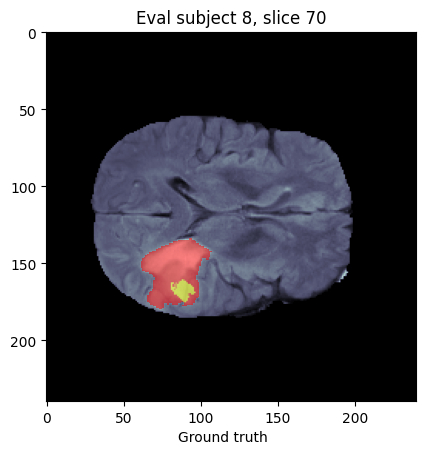

In [104]:
show_mri_and_label(IDX, 70, True)

In [136]:
def show_all(subject_num, slice_num, pred, train=False):
    plt.figure(figsize=(20, 20))
    f, ax = plt.subplots(2)
    # Show ground truth image
    ground_truth = val_dataset if not train else train_dataset
    ax[0].set_position([0, 0, 0.8, 0.8])
    ax[0].imshow(ground_truth[subject_num]["MRI"].data[0,:,:,slice_num], cmap="bone")
    ax[0].imshow(masked(ground_truth[subject_num]["Label"].data[0,:,:,slice_num]), alpha=0.5,
                                  cmap="autumn")
    title_start = "Training" if train else "Eval"
    ax[0].set_title(f"{title_start} subject {subject_num}, slice {slice_num} \n(ground truth)")
    # ax[0].legend("Ground truth", y=0.05, fontsize=10)
    
    # Show prediction image
    ground_truth = val_dataset if not train else train_dataset
    ax[1].set_position([0.75, 0, 0.8, 0.8])
    ax[1].imshow(ground_truth[subject_num]["MRI"].data[0,:,:,slice_num], cmap="bone")
    max_likelihood_pred = pred.argmax(0)
    ax[1].imshow(masked(max_likelihood_pred[:, :, slice_num]), alpha=0.5,
                                  cmap="autumn")
    title_start = "Training" if train else "Eval"
    ax[1].set_title(f"{title_start} subject {subject_num}, slice {slice_num} \n(pred)")
    # ax[0].legend("Prediction", y=0.05, fontsize=10)

<Figure size 2000x2000 with 0 Axes>

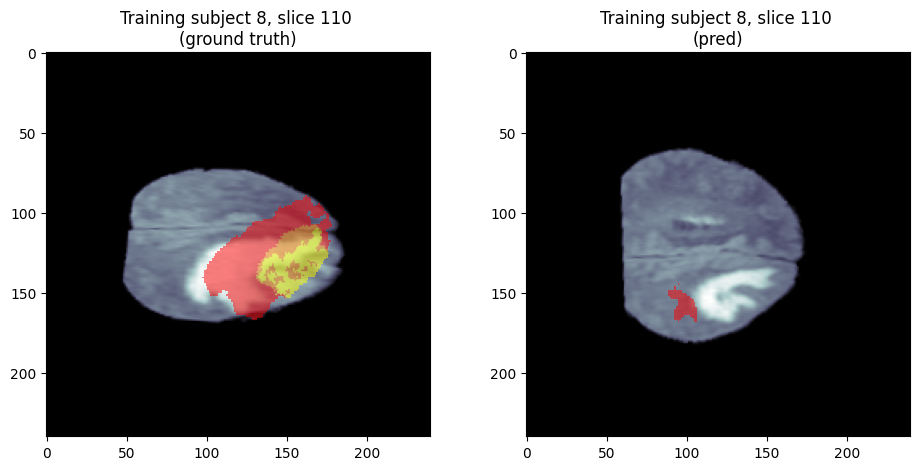

In [151]:
show_all(IDX, 110, pred, train=True)

In [26]:
subjects[12]["MRI"].data.unsqueeze(0).shape

torch.Size([1, 4, 240, 240, 155])

In [27]:
model(subjects[12]["MRI"].data.unsqueeze(0).cuda())

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 76 but got size 77 for tensor number 1 in the list.

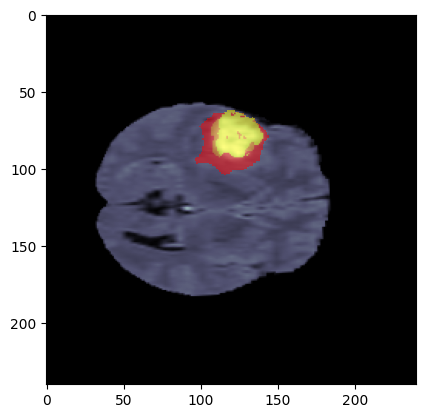

In [12]:
show_mri_and_label(3, 70, True)

In [ ]:
def show_mri_and_pred(subject_num, slice_num, model):
    plt.figure()
    plt.imshow(subjects[subject_num]["MRI"].data[0,:,:,slice_num], cmap="bone")
    if show_label:
        plt.imshow(masked(subjects[subject_num]["Label"].data[0,:,:,slice_num]), alpha=0.5,
                                  cmap="autumn")

In [ ]:
augmentation = {
    tio.RandomAffine(scales=(0.9, 1.1), degrees=(-25, 25)): 0,
    tio.RandomElasticDeformation(num_control_points=5): 1
}
pipeline = [
    tio.RandomElasticDeformation(num_control_points=10)
    # tio.RandomAffine(scales=(0.9, 1.1), degrees=(-25, 25))
]
pipeline2 = [
    tio.RandomAffine(scales=(1, 1), degrees=(0, 0), translation=(-20, 20, -20, 20, 0, 0))
]
new_data = tio.Compose(pipeline)(data).data
plt.figure()
plt.imshow(new_data[0, :, :, 70], cmap="bone")
plt.figure()
plt.imshow(data[0, :, :, 70], cmap="bone")

In [ ]:
        equality_tensor = pred == label
        print(f"Eq: {equality_tensor.shape}, {pred.shape}, {label.shape}")
        
        print(equality_tensor.sum(dim=(1,2,3)))
        pixels_per_image = equality_tensor.numel() / equality_tensor.shape[0]
        print(equality_tensor.sum(dim=(1,2)) / pixels_per_image)
        
        loss = torch.nn.CrossEntropyLoss(reduction="mean")(pred, label)
        total_loss += loss

In [ ]:
losses = np.array([0.4, 0.3, 0.5, 0.2, 1.0, 0.9, 0.9, 0.65, 0.56, 0.22, 0.12])
mod_losses = [(loss, index) for index, loss in enumerate(losses)]
sorted_losses = sorted(mod_losses)
print(sorted_losses)

# The loss of the worst prediction (0th percentile).
worst_loss, worst_index = sorted_losses[-1]
# The loss of the 25th percentile prediction.
perc_25_loss, perc_25_index = sorted_losses[int(len(sorted_losses) * 0.75)]
# The median loss of the predictions (50th percentile).
median_loss, median_index = sorted_losses[int(len(sorted_losses) * 0.5)]
# The loss of the 75th percentile prediction.
perc_75_loss, perc_75_index = sorted_losses[int(len(sorted_losses) * 0.25)]
# The loss of the best prediction (100th percentile).
best_loss, best_index = sorted_losses[0]

print(worst_loss, worst_index)
print(perc_25_loss, perc_25_index)
print(median_loss, median_index)
print(perc_75_loss, perc_75_index)
print(best_loss, best_index)